<a href="https://colab.research.google.com/github/gamagilang/purchaseanalytics/blob/main/purchase_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pickle

**Data Import**

In [ ]:
! git clone https://github.com/gamagilang/customeranalytics.git

fatal: destination path 'customeranalytics' already exists and is not an empty directory.


In [ ]:
df_purchase = pd.read_csv('customeranalytics/purchase data.csv')

**Data Exploration**

In [ ]:
df_purchase

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58688,200000500,703,0,0,0,2,1,1.41,1.85,2.01,2.24,2.79,0,0,1,0,0,0,0,42,1,120946,1,0
58689,200000500,710,0,0,0,0,0,1.36,1.84,2.09,2.24,2.77,0,0,0,0,0,0,0,42,1,120946,1,0
58690,200000500,717,0,0,0,0,0,1.50,1.80,2.14,2.24,2.75,0,0,0,0,0,0,0,42,1,120946,1,0
58691,200000500,722,1,2,3,0,0,1.51,1.82,2.09,2.24,2.80,0,0,0,0,0,0,0,42,1,120946,1,0


Note:
we can't conduct descriptive statistic analysis since there are more than 1 dataset for each customer and the number of the data points (number of purchase) vary from each of the costumer. the only way to explore the data is to conduct the data quality assesment for the dataset

In [ ]:
df_purchase.isnull().sum()

ID                   0
Day                  0
Incidence            0
Brand                0
Quantity             0
Last_Inc_Brand       0
Last_Inc_Quantity    0
Price_1              0
Price_2              0
Price_3              0
Price_4              0
Price_5              0
Promotion_1          0
Promotion_2          0
Promotion_3          0
Promotion_4          0
Promotion_5          0
Sex                  0
Marital status       0
Age                  0
Education            0
Income               0
Occupation           0
Settlement size      0
dtype: int64

**Data Segmentation**

Import Segmentation Model

In [ ]:
scaler = pickle.load(open('customeranalytics/scaler.pickle','rb'))
pca = pickle.load(open('customeranalytics/pca.pickle','rb'))
kmeans_pca = pickle.load(open('customeranalytics/kmeans_pca.pickle','rb'))

Note:
we wil not fit the pca and kmeans model to dataset, instead we will only transform the data using the model

Standardization

In [ ]:
features = df_purchase[['Sex', 'Marital status','Age','Education','Income','Occupation','Settlement size']]
df_purchase_segmentation_std = scaler.transform(features)

PCA
- we will need the principal component scores from these seven feature. in a similar manner, we use PCI transform on our standardize feature

In [ ]:
df_purchase_segmentation_pca = pca.transform(df_purchase_segmentation_std)

In [ ]:
df_purchase_segmentation_pca

array([[ 0.36215223, -0.63955673,  1.46270631],
       [ 0.36215223, -0.63955673,  1.46270631],
       [ 0.36215223, -0.63955673,  1.46270631],
       ...,
       [ 0.3617637 , -0.7398037 ,  1.15875419],
       [ 0.3617637 , -0.7398037 ,  1.15875419],
       [ 0.3617637 , -0.7398037 ,  1.15875419]])

K-means PCA

- Kmeans has the predict method that could implement the algorithm made from previous model to the new datasets (new customer) in order to see the new customer buying behaviour

In [ ]:
purchase_segmentation_kmeans_pca = kmeans_pca.predict(df_purchase_segmentation_pca)

In [ ]:
df_purchase_predictors = df_purchase.copy()
df_purchase_predictors['Segment'] = purchase_segmentation_kmeans_pca

**Descriptive Analysis by Segments**

Data Analysis by Customer

In [ ]:
df_purchase_predictors.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,0,0,47,1,110866,1,0,1
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,1
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,1
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,1
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,0,0,47,1,110866,1,0,1


Note: 
We may be interested in having one record per individual in order to analyze the data on an infividual. So with that in mind, we are going to create a new dataframe which sumirize each customer's purchasing behavior. 

In [ ]:
# Creating a temporary variable (number of visit)
temp1 = df_purchase_predictors[['ID','Incidence']].groupby(['ID'], as_index =False).count()
#temp1 = temp1.set_index('ID')
temp1 = temp1.rename(columns ={'Incidence':'N_visits'})
temp1

,ID,N_visits
0,200000001,101
1,200000002,87
2,200000003,97
3,200000004,85
4,200000005,111
...,...,...
495,200000496,120
496,200000497,120
497,200000498,131
498,200000499,106


In [ ]:
temp2 = df_purchase_predictors[['ID','Incidence']].groupby(['ID'], as_index = False).sum()
temp2 = temp2.rename(columns ={'Incidence':'N_purchase'})
temp2.tail()

,ID,N_purchase
495,200000496,20
496,200000497,43
497,200000498,39
498,200000499,31
499,200000500,15


In [ ]:
purchase_descr = pd.merge(temp1,temp2,how='inner',on='ID')
purchase_descr.head()

,ID,N_visits,N_purchase
0,200000001,101,9
1,200000002,87,11
2,200000003,97,10
3,200000004,85,11
4,200000005,111,13


In [ ]:
purchase_descr['Average N_purchase'] = purchase_descr['N_purchase']/purchase_descr['N_visits']
purchase_descr= pd.merge(purchase_descr,df_purchase_predictors[['ID','Segment']], on='ID', how='left')

In [ ]:
purchase_descr = purchase_descr.drop_duplicates().reset_index().drop(columns = 'index', axis = 1)
purchase_descr

,ID,N_visits,N_purchase,Average N_purchase,Segment
0,200000001,101,9,0.089109,1
1,200000002,87,11,0.126437,0
2,200000003,97,10,0.103093,1
3,200000004,85,11,0.129412,1
4,200000005,111,13,0.117117,3
...,...,...,...,...,...
495,200000496,120,20,0.166667,2
496,200000497,120,43,0.358333,1
497,200000498,131,39,0.297710,2
498,200000499,106,31,0.292453,1


Segment Proportion

In [ ]:
segment_prop = purchase_descr[['Segment','N_purchase']].groupby(['Segment']).count()/purchase_descr.shape[0]
segment_prop = segment_prop.rename(columns= {'N_purchase':'Segment Proportions'})
segment_prop

,Segment Proportions
Segment,
0,0.196
1,0.376
2,0.208
3,0.220


Text(0.5, 1.0, 'Segment Proportions')

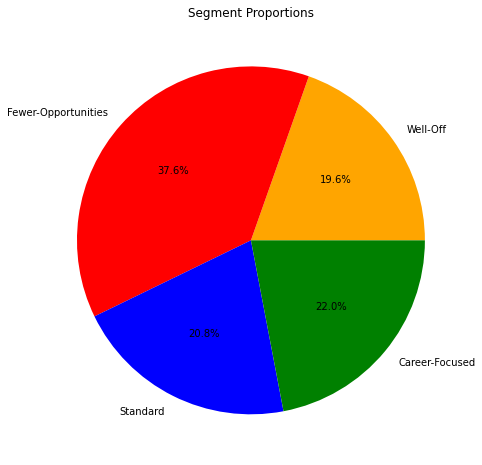

In [ ]:
plt.figure(figsize=(10,8))
plt.pie(segment_prop['Segment Proportions'],
        labels = ['Well-Off','Fewer-Opportunities','Standard','Career-Focused'],
        autopct='%1.1f%%',
        colors = ('orange','r','b','g'))
plt.title('Segment Proportions')

Note: 

- The fewer opportunities segment in new customer data has largest population amongs other segments with the 37.6% from total customer.
- the standard, well-off, and career focused almost equaly distributed

**Purchase Occasions and Purchase Incidence**

In [ ]:
segment_mean = purchase_descr.groupby(['Segment']).mean().drop(columns = 'ID', axis = 1)
segment_mean

,N_visits,N_purchase,Average N_purchase
Segment,,,
0,117.295918,34.602041,0.284478
1,113.835106,22.792553,0.201755
2,117.471154,24.817308,0.212364
3,123.454545,39.827273,0.283102


In [ ]:
segment_std = purchase_descr.groupby(['Segment']).std()

In [ ]:
segment_std

,ID,N_visits,N_purchase,Average N_purchase
Segment,,,,
0,138.348402,20.716152,25.900579,0.171787
1,152.925187,16.390601,13.843068,0.120634
2,136.738664,19.088937,16.715648,0.126056
3,133.502438,44.864656,53.744530,0.200056


Text(0, 0.5, 'Number of Store Visits')

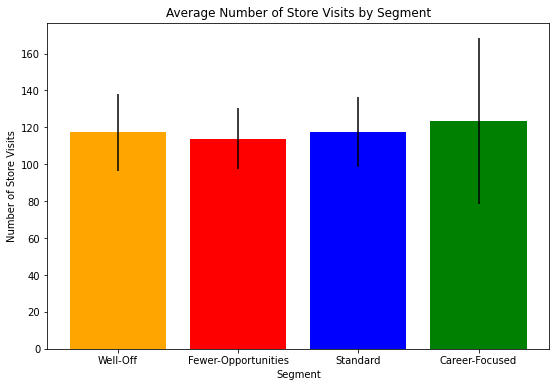

In [ ]:
plt.figure(figsize = (9,6))
plt.bar(x = (0,1,2,3),
        tick_label =('Well-Off','Fewer-Opportunities','Standard','Career-Focused'),
        height = segment_mean['N_visits'],
        yerr = segment_std['N_visits'],
        color = ('orange','r','b','g'))
plt.title('Average Number of Store Visits by Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Store Visits')

Note:
- the fewer opportunities visits the store least often
- the career focused visits the store the most but the std is quite high which implies the customer in this segment are homogenous that is least alike when it comes to how often they visits the store
- the 

Text(0, 0.5, 'Purchase Incidences')

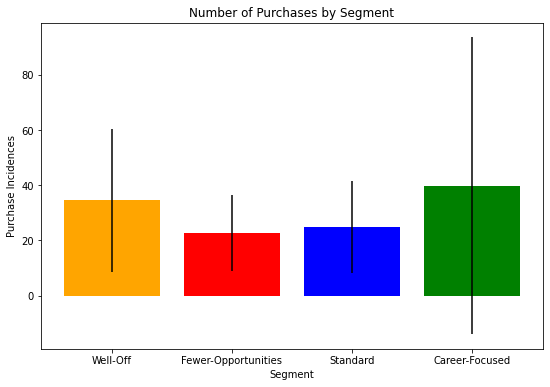

In [ ]:
plt.figure(figsize = (9,6))
plt.bar(x = (0,1,2,3),
        tick_label =('Well-Off','Fewer-Opportunities','Standard','Career-Focused'),
        height = segment_mean['N_purchase'],
        yerr = segment_std['N_purchase'],
        color = ('orange','r','b','g'))
plt.title('Number of Purchases by Segment')
plt.xlabel('Segment')
plt.ylabel('Purchase Incidences')

Note:
- career focused buys product most often but the std is high which means there is some people buys product very often while others buys less often in the segment
- the most homogenous segment is fewer opportunities with the lowest std

Text(0, 0.5, 'Average Purchase Incidences')

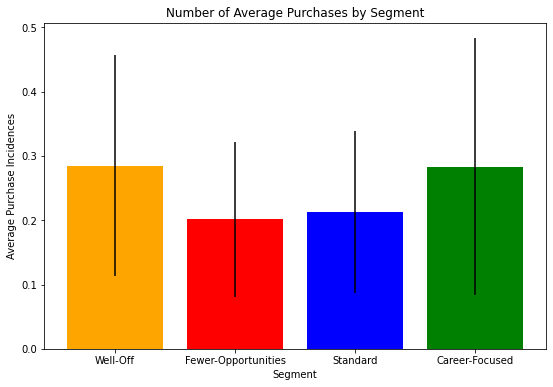

In [ ]:
plt.figure(figsize = (9,6))
plt.bar(x = (0,1,2,3),
        tick_label =('Well-Off','Fewer-Opportunities','Standard','Career-Focused'),
        height = segment_mean['Average N_purchase'],
        yerr = segment_std['Average N_purchase'],
        color = ('orange','r','b','g'))
plt.title('Number of Average Purchases by Segment')
plt.xlabel('Segment')
plt.ylabel('Average Purchase Incidences')

**Brand Choice**

In [ ]:
df_purchase_incidence = df_purchase_predictors[df_purchase_predictors['Incidence'] == 1]

In [ ]:
df_purchase_incidence.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,2.09,2.67,0,0,0,0,0,0,0,47,1,110866,1,0,1
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,2.12,2.62,1,0,0,0,1,0,0,47,1,110866,1,0,1
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,1.97,2.67,0,0,0,1,0,0,0,47,1,110866,1,0,1
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,2.16,2.68,1,1,0,0,0,0,0,47,1,110866,1,0,1
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,1.89,2.37,1,0,0,1,1,0,0,47,1,110866,1,0,1


In [ ]:
brand_dummies = pd.get_dummies(df_purchase_incidence['Brand'], prefix = 'Brand', prefix_sep = '_')
brand_dummies['Segment'], brand_dummies['ID'] = df_purchase_incidence

In [ ]:
brand_dummies

,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
6,0,1,0,0,0
11,0,0,0,0,1
19,1,0,0,0,0
24,0,0,0,1,0
29,0,1,0,0,0
...,...,...,...,...,...
58621,0,1,0,0,0
58648,1,0,0,0,0
58674,0,1,0,0,0
58687,0,1,0,0,0


In [ ]:
brand_dummies['index']

KeyError: ignored